# jif3D Tutorial 3 -- joint inversion with a cross-gradient

Now that we have performed individual inversions with each dataset, we are ready to perform a joint inversion of the two. We will start with the well-established cross-gradient based approach (Gallardo, L. A., & Meju, M. A. (2004). Joint two‐dimensional DC resistivity and seismic travel time inversion with cross‐gradients constraints. Journal of Geophysical Research: Solid Earth, 109(B3)). The cross-gradient aims at making anomalies in the two models look similar in a general sense. 

In our example with a density model $\mathbf{m}_{dens}$ and a susceptibility model  $\mathbf{m}_{dens}$ the cross-gradient is defined as
$$ \Phi_{cg}(\mathbf{m}_{dens}, \mathbf{m}_{sus}) = \left( \nabla \mathbf{m}_{dens} \times \nabla \mathbf{m}_{sus} \right)^2, $$
where $\nabla$ is the spatial gradient (the variation of values between adjacent model cells) and $\times$ denotes the cross-product (hence the name cross-gradient). We can introduce this term into the objective function and the total quantity to minimize then becomes
$$ \Phi(\mathbf{m}_{dens}, \mathbf{m}_{sus}) = \lambda_1 \Phi_{grav}(\mathbf{m}_{dens}) +  \lambda_2 \Phi_{mag}(\mathbf{m}_{sus}) + \lambda_3 \Phi_{reg,grav}(\mathbf{m}_{dens}) + \lambda_4 \Phi_{reg,mag}(\mathbf{m}_{sus})
+ \lambda_5 \Phi_{cg}(\mathbf{m}_{dens}, \mathbf{m}_{sus}).$$

So we have two data misfit terms, two regularization terms and the coupling that need to be balanced. Here some of the work we performed during the individual inversions pays out. In my experience the regularization parameters that work best for the individual inversions also work for cross-gradient based inversion. So we can use these as starting values for our joint inversion. In some cases we have to adjust the balance between the different datasets by increasing the weight for one of them. This can be the case if the inversion only works on one dataset and largely neglects the other. In this example this does not seem to be a problem. Therefore the only thing we have to adjust is the coupling between the datasets by adjusting the corresponding weight.

We want to find a model that fits both datasets as well as the individual inversions but has increased structural similarity indicated by a low cross-gradient value.

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt

## Running the inversion
Compared to the individual inversions, running a joint inversion simply means setting the weights for scalar gravity and magnetic to 1, specifying all inversion meshes and data files, setting the two regularization weights and the weight for the cross-gradient. Thus the run script below is only a slight modification from the previous two tutorials.

In [31]:
#location of the jif3D executables on your system
execpath = "/home/max/workspace/jif3D/bin/"
#program we want to run
progname = "grav_jointinv"
options = " --inclination 0.17 --declination 1.17 --fieldstrength 51184 "
#name of the density starting mesh
gravmesh = "../Tutorial1/start_grav.nc"
#name of the gravity data file
gravdata = "../Tutorial1/gravdata.nc"
#name of the susecptibility starting mesh
magmesh = "../Tutorial2/start_mag.nc"
#name of the magnetics data file
magdata = "../Tutorial2/magdata.nc"
#weight for standard gravity data, set to 1
gravweight = 1.0
#weight for the magnetic data, set to 1 as well for joint inversion
magweight = 1.0
#weight for the FTG data, set to zero at the moment as we do not have FTG data 
ftgweight = 0
#weight for the density regularization, use value from Tutorial 1
gravregularization = 100.0
#weight for susceptibility regularization, use value from Tutorial 2
magregularization = 100.0
# weight for the coupling term, higher means stronger influence of cross-gradient = more similar models
coupling = 1e5
#maximum number of iterations, CG tends to converge more slowly, so we bump it up again
iterations = 100
#write all information to file
f = open('run', 'w')
f.write(execpath+progname+options+" <<eof \n")    
f.write(magmesh+"\n")
f.write(str(gravweight)+"\n")
f.write(str(ftgweight)+"\n")
f.write(gravdata+"\n")
f.write(gravmesh+"\n")
f.write(str(magweight)+"\n")
f.write(magdata+"\n")
f.write(magmesh+"\n")
f.write(str(gravregularization)+"\n")
f.write(str(magregularization)+"\n")
f.write(str(coupling)+"\n")
f.write(str(iterations)+"\n")
f.write("eof\n")
f.close()

Once we have specified the type of inversion, the files and weights, running the scripts works exactly as before.

In [32]:
import subprocess
outfile = open("jif3dcrossout.out",'w')
subprocess.run(["bash ./run", ""],stdout=outfile,shell=True)
outfile.close()
log = open("jif3dcrossout.out",'r')
for line in log:
    print(line)

Mesh filename: Scalar Gravimetry Lambda: FTG Lambda: Scalar Gravity Data Filename: Gravity Model Filename: Scalar Gravity ndata: 836

Scalar Gravity lambda: 1

Magnetics Lambda: Total field magnetic Data Filename: Magnetics Model Filename:  Magnetics ndata: 830

 Magnetics lambda: 1

Gravity Regularization Lambda: Magnetics Regularization Lambda: Cross-gradient weight: Performing inversion.

Maximum number of iterations:         ScalGrav        Magnetics          GravReg           MagReg            Cross 

          757151      1.20219e+06                0                0                0 

Runtimes: 

              11               36                0                0                0 



Iteration: 0

        ScalGrav        Magnetics          GravReg           MagReg            Cross 

          757151      1.20219e+06                0                0                0 

Runtimes: 

               0                0                0                0                0 



Individual 

As before it is useful to look at the development of the different terms of the objective function during the inversion. The *misfit.out* file now has the columns: iteration, gravity misfit, magnetic misfit, gravity regularization, magnetic regularization and cross-gradient term. To make the plots a bit more compact we plot the two data RMS and the model roughness for both data/models together as we want to have a close look at the cross-gradient as well. We can see that the cross-gradient values are much smaller in magnitude compared to everything else. That is one reason why we need to choose a weight to make sure that it participates in the inversion.

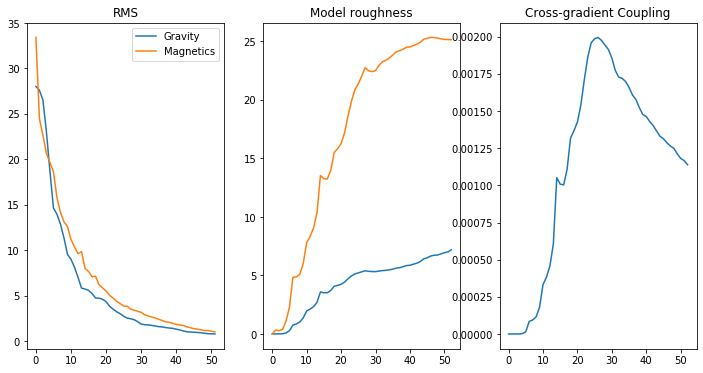

In [33]:
misfit = np.genfromtxt("misfit.out")
rms = np.genfromtxt("rms.out")
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(rms[:,1],label='Gravity')
plt.plot(rms[:,2],label='Magnetics')
plt.legend()
plt.title("RMS")
plt.subplot(132)
plt.plot(misfit[:,4])
plt.plot(misfit[:,5])
plt.title("Model roughness")
plt.subplot(133)
plt.plot(misfit[:,6])
plt.title("Cross-gradient Coupling")
plt.show()

We compare horizontal slices through the models. At first glance there is no significant difference to the individual inversion results. Without further tests it is unclear though whether this is due to the relatively relaxed similarity criterion defined by the cross-gradient or if the coupling is too weak. This will be one of the tasks to explore in this tutorial.

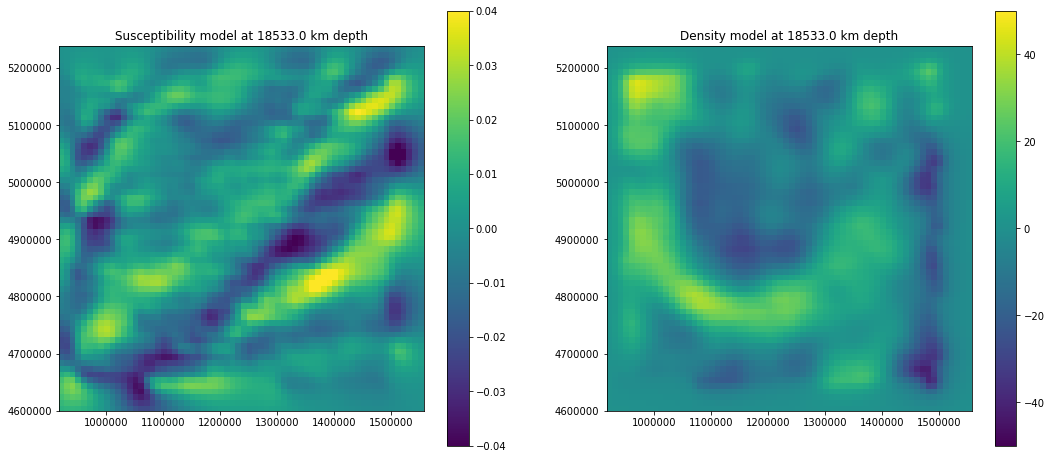

In [37]:
#the index of horizontal layer we want to plot, larger numbers = deeper, maximum 29 (nz-1)
depthindex = 10

#read in inversion model
mag_fh = Dataset("result.mag.inv.nc")
Northing =mag_fh.variables["Northing"][:]
Easting =mag_fh.variables["Easting"][:]
Depth =mag_fh.variables["Depth"][:]
Northing_Origin =mag_fh.variables["Northing_Origin"][:]
Easting_Origin =mag_fh.variables["Easting_Origin"][:]
Depth_Origin =mag_fh.variables["Depth_Origin"][:]
invsus = mag_fh.variables["Susceptibility"][:,:,:]
mag_fh.close()

grav_fh = Dataset("result.grav.inv.nc")
invdens = grav_fh.variables["Density"][:,:,:]
grav_fh.close()

pe = np.append(Easting_Origin,Easting)
pn = np.append(Northing_Origin,Northing)
pd = np.append(Depth_Origin,Depth)

plt.figure(figsize = (18,8))
plt.subplot(121)
mx, my = np.meshgrid(pe,pn)
psus = np.transpose(invsus[depthindex,:,:])
plt.pcolormesh(mx,my,psus,vmin=-0.04,vmax=0.04)
plt.title("Susceptibility model at {} km depth".format(Depth[depthindex]))
plt.gca().set_aspect(1)
plt.colorbar()

plt.subplot(122)
pdens = np.transpose(invdens[depthindex,:,:])
plt.pcolormesh(mx,my,pdens,vmin=-50,vmax=50)
plt.title("Density model at {} km depth".format(Depth[depthindex]))
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

We also plot two horizontal slices. These confirm our impression that there has been little interaction between the datasets. The two slices do not look particularly similar and the anomalies still extend through large parts of the inversion domain.

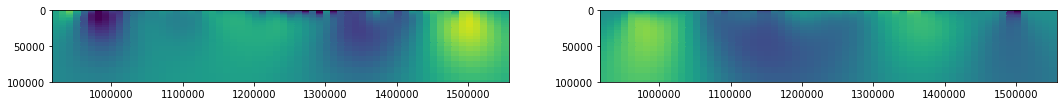

In [43]:
#the index of the East-West slice, larger numbers = further north, maximum 63 (nx-1)
northindex = 32
plt.figure(figsize = (18,8))

plt.subplot(121)
mx, my = np.meshgrid(pe,pd)
plt.pcolormesh(mx,my,invsus[:,:,northindex],vmin=-0.04,vmax=0.04)
plt.ylim([100000,0])
plt.gca().set_aspect(1)

plt.subplot(122)
plt.pcolormesh(mx,my,invdens[:,:,northindex],vmin=-50,vmax=50)
plt.ylim([100000,0])
plt.gca().set_aspect(1)
plt.show()

It is helpful to investigate where the inversion thinks the models are dissimilar (high cross-gradient value) and where they are considered similar (low cross-gradient value). The program outputs a file *Cross.cg_abs.nc* in the same format as the density model. This contains the cross-gradient constraint value for every model cell. The fact that it reuses the density model format instead of defining its own variable name is half convenience half lazyness. It makes it a bit easier to reuse plotting scripts and alleviates the programmer from coming up with many meaningful names. This lazy approach is used for some other outputs in *jif3D* as well, but might change in the future depending on how problematic this becomes as time goes on.

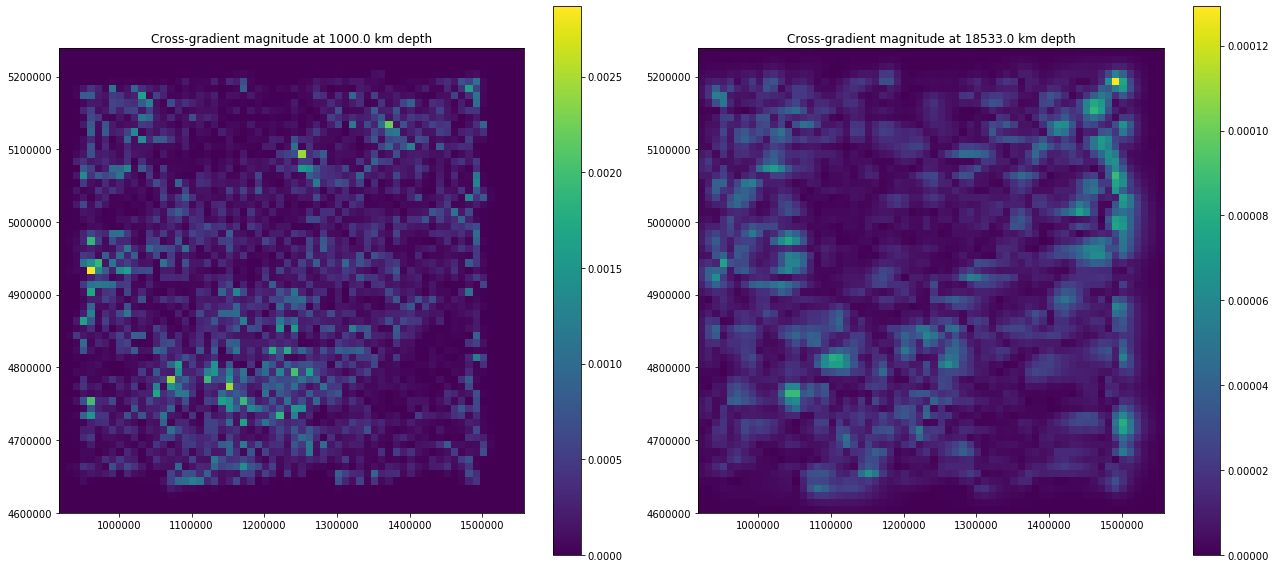

In [39]:
#Read in data calculated from the final model
#read in cross-gradient magnitude
cross_fh = Dataset("Cross.cg_abs.nc")
invcross = cross_fh.variables["Density"][:,:,:]
cross_fh.close()

depthindex1 = 0
plt.figure(figsize = (18,8))
plt.subplot(121)
pcross = np.transpose(invcross[depthindex1,:,:])
plt.pcolormesh(mx,my,pcross)
plt.title("Cross-gradient magnitude at {} km depth".format(Depth[depthindex1]))
plt.gca().set_aspect(1)
plt.colorbar()
depthindex2 = 10
plt.subplot(122)
pcross = np.transpose(invcross[depthindex2,:,:])
plt.pcolormesh(mx,my,pcross)
plt.title("Cross-gradient magnitude at {} km depth".format(Depth[depthindex2]))
plt.gca().set_aspect(1)
plt.colorbar()
plt.tight_layout()
plt.show()


In addition to the models itself, the relationship between different parameters is a quantity of interest. For example different geological units should cluster around different values. We therefore make crossplots of density vs. susceptibility for the whole model domain (left) and for the horizontal slices plotted above. There have been examples of successfully extracting such parameter relationships from cross-gradient based inversion(e.g. Moorkamp, M., Roberts, A. W., Jegen, M., Heincke, B., & Hobbs, R. W. (2013). Verification of velocity‐resistivity relationships derived from structural joint inversion with borehole data. Geophysical Research Letters, 40(14), 3596-3601.), however, in this case we cannot really identify distinct units.

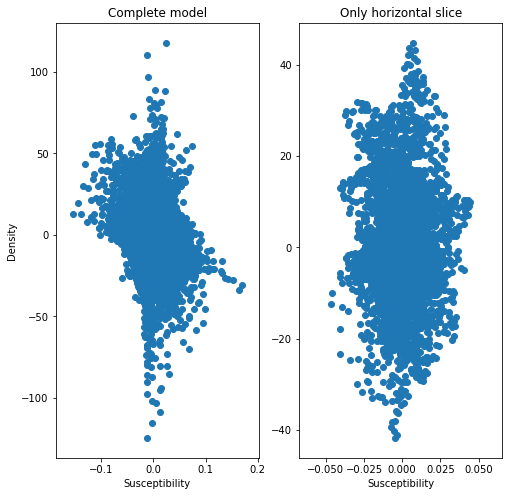

In [47]:
plt.figure(figsize = (8,8))
plt.subplot(121)
plt.scatter(invsus.flatten(),invdens.flatten())
plt.title("Complete model")
plt.xlabel("Susceptibility")
plt.ylabel("Density")
plt.subplot(122)
plt.scatter(psus.flatten(),pdens.flatten())
plt.title("Only horizontal slice")
plt.xlabel("Susceptibility")
plt.show()

## Tasks

- Find the maximum cross-gradient weight that still produces a reasonable fit to the data, i.e. comparable to the individual inversions. Increase the original weight by a factor of ten until you deem the fit unsatisfactory
- Observe what happens to the model and the cross-gradient plots when changing the weight